<a href="https://colab.research.google.com/github/kicysh/final_task_of_world_model_lecture_2021/blob/main/src/LDVAE_new_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setting

以下の文献を参考にした
- [【seed、本当に固定できた?】PyTorchの再現性に関して公式資料を読む](https://qiita.com/north_redwing/items/1e153139125d37829d2d)

## パラメータ

In [80]:
# setting

RANDOM_SEED = 42

# 前処理
SETTING_N_TOP_GENES = 1000
SETTING_GENES_SELECT_FLAVOR = 'seurat_v3'

SETTING_BATCHNORM_MOMENTUM = 0.01
SETTING_ENCODER_Z_DROPOUT_P = 0.1
SETTING_ENCODER_L_DROPOUT_P = 0.1
SETTING_HIDDEN_DIMS = 128
SETTING_LATENT_DIM = 8

# epsの設定
SETTING_EPS = 1e-8
SETTING_BATCHNORM_EPS = None

TRAIN_RATE = 0.8
VAL_RATE = 0.2

USE_CUDA = True
SETTING_BATCH_SIZE = 1024

In [81]:
# setting
if SETTING_BATCHNORM_EPS is None:
    SETTING_BATCHNORM_EPS = SETTING_EPS

# setting assert
assert TRAIN_RATE + VAL_RATE <= 1, 'TRAIN_RATE+VAL_RATE は１以下である必要があります'


## data download

In [82]:
# data: dataの場所
# figures: 作成された図の保存場所

!mkdir data figures

import gdown
gdown.download('https://drive.google.com/uc?id=1PedYqkkEClou4iQQbfrAkmHVydiJrQVb', '/content/data/train_data.h5ad', quiet=False,)
path_of_data = '/content/data/train_data.h5ad'


mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘figures’: File exists


Downloading...
From: https://drive.google.com/uc?id=1PedYqkkEClou4iQQbfrAkmHVydiJrQVb
To: /content/data/train_data.h5ad
100%|██████████| 23.5M/23.5M [00:00<00:00, 93.8MB/s]


## pip install

In [4]:
!pip install scanpy scikit-misc

     |████████████████████████████████| 2.0 MB 8.6 MB/s 
     |████████████████████████████████| 8.8 MB 33.8 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 96 kB 4.6 MB/s 
     |████████████████████████████████| 1.1 MB 61.8 MB/s 
     |████████████████████████████████| 63 kB 2.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=4e82a973a21ef966f9d80d02f3acec9cfa98c1f45a76a6dcfe2c0b24c1266b1b
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=193b054d779d73cb00b6d667e1f61621c3a6f3c56a0a6bc07f094aa7a2df4b08
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=1e8148f731b76825ca67929bb35a9abf5d4cb7346d578

## import

In [5]:
# import
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import logsumexp
from torch.distributions import Normal, kl_divergence

import matplotlib.pyplot as plt

import scanpy as sc

## 再現性を保つための設定

In [6]:
# random seed の設定

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# dataloader用
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(RANDOM_SEED)

# dataloaderで以下のように設定する必要があります
#
#DataLoader(
#    train_dataset,
#    batch_size=batch_size,
#    num_workers=num_workers,
#    worker_init_fn=seed_worker
#    generator=g,
#)


# data

In [7]:
adata = sc.read_h5ad(path_of_data)

# n_top_genesで選んだ遺伝子数をつける
sc.pp.highly_variable_genes(adata,n_top_genes=SETTING_N_TOP_GENES ,flavor=SETTING_GENES_SELECT_FLAVOR)

# 選んだ遺伝子のindexを保持する
gene_index = adata.var[adata.var['highly_variable']].index

# view condition and cell_type
for col in ['condition','cell_type']:
    print(adata.obs[col].value_counts(), end='\n\n')

print(adata)

# 選んだ遺伝子のみ存在するdataframeをadata_dfとする
adata_df = adata.to_df()[gene_index]
print(f'adata_df.shape is {adata_df.shape}')


/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,


stimulated    8886
control       8007
Name: condition, dtype: int64

CD4T           5564
FCGR3A+Mono    3601
CD14+Mono      2561
B              1811
NK             1163
CD8T           1115
Dendritic      1078
Name: cell_type, dtype: int64

AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'
adata_df.shape is (16893, 1000)


In [8]:
class GenesDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 adata, 
                 transform=None, 
                 target_transform=None):
        self.data = adata
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getattr__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        if self.transform:
            data = self.transform(data)
        return data

In [9]:
# dataloder
dataset = GenesDataset(adata_df.values)


n_samples = len(dataset) 
train_size = int(n_samples* TRAIN_RATE)
val_size = int(n_samples * VAL_RATE)
test_size = n_samples - train_size - val_size 

dataset_train ,dataset_valid, dataset_test = \
        torch.utils.data.random_split(dataset, [train_size, val_size,test_size])

dataloader_all = torch.utils.data.DataLoader(
    dataset,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=False,
    worker_init_fn=seed_worker,
    generator=g,
)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
)

dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
)

# model

In [13]:

class LDVAE(nn.Module):
    """
    :param genes_cnt: Number of input genes
    :param latent_dim: Dimensionality of the latent space 
    """
    def __init__(
        self,
        genes_cnt: int, 
        hidden_dims: tuple,
        hidden_l_dims: tuple= (128,),
        latent_dim: int = 20
    ):
        super(LDVAE,self).__init__()
        self.local_l_mean = None
        self.local_l_std = None
        self.hidden_dims = hidden_dims
        self.eps = SETTING_EPS

        self.theta = nn.Parameter(torch.randn(genes_cnt))
        encoder_layers = []
        old_dim = genes_cnt
        for dim in hidden_dims:
            encoder_layers.append(nn.Linear(old_dim, dim))
            encoder_layers.append(nn.BatchNorm1d(dim,
                                                eps=SETTING_BATCHNORM_EPS, 
                                                momentum=SETTING_BATCHNORM_MOMENTUM))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(SETTING_ENCODER_Z_DROPOUT_P))
            old_dim = dim
        self.encoder_z = nn.Sequential(*encoder_layers)
        self.encoder_z_mean = nn.Linear(hidden_dims[-1],latent_dim)
        self.encoder_z_std = nn.Linear(hidden_dims[-1],latent_dim)

        encoder_layers = []
        in_dim = genes_cnt
        for dim in hidden_l_dims:
            encoder_layers.append(nn.Linear(in_dim, dim))
            encoder_layers.append(nn.BatchNorm1d(dim,
                                                eps=SETTING_BATCHNORM_EPS, 
                                                momentum=SETTING_BATCHNORM_MOMENTUM))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(SETTING_ENCODER_Z_DROPOUT_P))
            in_dim = dim
        self.encoder_l = nn.Sequential(*encoder_layers)
        self.encoder_l_mean = nn.Linear(hidden_l_dims[-1],1)
        self.encoder_l_std = nn.Linear(hidden_l_dims[-1],1)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, genes_cnt,bias=False),#bias=False
            nn.BatchNorm1d(genes_cnt,
                           eps=SETTING_BATCHNORM_EPS, 
                           momentum=SETTING_BATCHNORM_MOMENTUM)
        )


    def forward(self,x):
        x_z = self.encoder_z(x)
        z_mean = self.encoder_z_mean(x_z)
        z_std = torch.exp(torch.clip(self.encoder_z_std(x_z),max=10)) 
        #z = Normal(z_mean, z_std.sqrt()).rsample()
        z_eps = torch.randn(z_mean.shape).to('cuda' if next(self.parameters()).is_cuda else 'cpu')
        z = z_mean + z_std * z_eps


        x_l = self.encoder_l(x)
        l_mean = self.encoder_l_mean(x_l)
        l_std = torch.exp(torch.clip(self.encoder_l_std(x_l),max=10))
        #library = Normal(l_mean, l_std.sqrt()).rsample()
        l_eps = torch.randn(l_mean.shape).to('cuda' if next(self.parameters()).is_cuda else 'cpu')
        library = (l_mean + l_std * l_eps)

        y = self.decoder(z)
        y = torch.exp(torch.clip(library,max=10))*torch.softmax(y, dim=-1)
        return [z_mean, z_std, z], [l_mean, l_std, library], y


    def set_local_l_mean_and_std(self, data):
        masked_log_sum =np.ma.log(data.sum(axis=1))
        log_counts = masked_log_sum.filled(0)
        self.local_l_mean = (np.mean(log_counts).reshape(-1, 1)).astype(np.float32)[0][0]
        self.local_l_std = (np.var(log_counts).reshape(-1, 1)).astype(np.float32)[0][0]
        return self.local_l_mean, self.local_l_std


    def reconst_error(self,x, mu, theta):
        eps = SETTING_EPS
        log_theta_mu_eps = torch.log(theta + mu + eps)

        res = (
            theta * (torch.log(theta + eps) - log_theta_mu_eps)
            + x * (torch.log(mu + eps) - log_theta_mu_eps)
            + torch.lgamma(x + theta)
            - torch.lgamma(theta)
            - torch.lgamma(x + 1)
        )
        return res


    def loss(self,x):
        zs,ls,y = self.forward(x)
        z_mean, z_std, z = zs
        l_mean, l_std, library = ls

        mean, std = torch.zeros_like(z_mean), torch.ones_like(z_std)
        kl_z = kl_divergence(Normal(z_mean,torch.sqrt(z_std)), Normal(mean, std)).sum(dim=1)

        mean, std = self.local_l_mean*torch.ones_like(l_mean), self.local_l_std*torch.ones_like(l_std)
        kl_l = kl_divergence(Normal(l_mean,torch.sqrt(l_std)), Normal(mean, torch.sqrt(std))).sum(dim=1)

        reconst = self.reconst_error(x, mu=y, theta=torch.exp(self.theta)).sum(dim=-1)        
        return reconst, kl_l ,kl_z

In [56]:
model = LDVAE(genes_cnt = len(adata_df.columns),
              hidden_dims=(512,128,16),
              hidden_l_dims=(128,),
              latent_dim = SETTING_LATENT_DIM)
model.set_local_l_mean_and_std(adata_df.values)
model

LDVAE(
  (encoder_z): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-08, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-08, momentum=0.01, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=128, out_features=16, bias=True)
    (9): BatchNorm1d(16, eps=1e-08, momentum=0.01, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (encoder_z_mean): Linear(in_features=16, out_features=10, bias=True)
  (encoder_z_std): Linear(in_features=16, out_features=10, bias=True)
  (encoder_l): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-08, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU()

In [57]:

n_epochs  = 100
optimizer = optim.Adam(model.parameters(), lr=7e-3)#  betas=(0.5,0.999))

device = 'cuda'  if USE_CUDA else 'cpu'
model.to(device)
#_x = nonzero

for epoch in range(n_epochs):
    losses = []

    model.train()
    for x in dataloader_train:
        x = x.to(device)
        #_x = x

        model.zero_grad()

        # forawrd and loss
        reconst, kl_l ,kl_z = model.loss(x)
        loss = torch.mean(-reconst+kl_l +kl_z)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())

    losses_val1 = []
    losses_val2 = []
    losses_val3 = []

    model.eval()
    for x in dataloader_valid:

        x = x.to(device)


        reconst, kl_l ,kl_z = model.loss(x)

        losses_val1.append(torch.mean(-reconst).cpu().detach().numpy())
        losses_val2.append(torch.mean(kl_l).cpu().detach().numpy())
        losses_val3.append(torch.mean(kl_z).cpu().detach().numpy())

    print('EPOCH: %d    Train Loss: %lf    Valid rec: %lf    Valid kl_l: %lf    Valid kl_z: %lf' %
            (epoch+1, np.average(losses),np.average(losses_val1),np.average(losses_val2),np.average(losses_val3)))


EPOCH: 1    Train Loss: 411.703339    Valid rec: 927.246704    Valid kl_l: 53.767365    Valid kl_z: 106.543083
EPOCH: 2    Train Loss: 275.993561    Valid rec: 374.528778    Valid kl_l: 61.267117    Valid kl_z: 188.686371
EPOCH: 3    Train Loss: 237.882172    Valid rec: 962.016296    Valid kl_l: 55.588058    Valid kl_z: 40.976440
EPOCH: 4    Train Loss: 220.294022    Valid rec: 873.870117    Valid kl_l: 38.406029    Valid kl_z: 23.761993
EPOCH: 5    Train Loss: 209.681229    Valid rec: 797.091431    Valid kl_l: 30.405624    Valid kl_z: 12.348456
EPOCH: 6    Train Loss: 201.880463    Valid rec: 766.451172    Valid kl_l: 27.803005    Valid kl_z: 8.155305
EPOCH: 7    Train Loss: 195.579254    Valid rec: 573.472168    Valid kl_l: 20.051914    Valid kl_z: 6.824255
EPOCH: 8    Train Loss: 190.626358    Valid rec: 403.727905    Valid kl_l: 12.805404    Valid kl_z: 6.536794
EPOCH: 9    Train Loss: 185.970230    Valid rec: 312.666351    Valid kl_l: 8.379034    Valid kl_z: 5.985778
EPOCH: 10    

In [58]:
# w
import pandas as pd

_w = model.decoder[0].weight
bn = model.decoder[1]
sigma = torch.sqrt(bn.running_var + bn.eps)
gamma = bn.weight
b = gamma / sigma
bI = torch.diag(b)
loadings = torch.matmul(bI, _w)
loadings = loadings.detach().cpu().numpy()

W = pd.DataFrame(loadings, index=gene_index)
W.to_csv('/content/w.csv')


In [59]:
W.head()

,0,1,2,3,4,5,6,7,8,9
index,,,,,,,,,,
HES4,-0.334052,-0.185747,0.192274,0.524578,-0.001543,-0.067074,0.386076,-0.054357,-2.188222,-0.172468
ISG15,0.635795,-0.163792,0.202517,0.249201,0.012856,0.042065,0.139395,-0.079106,-1.718191,-0.229430
TNFRSF18,0.371326,-0.171078,0.214424,0.234019,0.040203,-1.258242,0.973621,-0.411250,0.973032,-0.238369
TNFRSF4,0.707782,-0.163111,0.183013,0.490354,0.001345,-0.534099,-0.013133,-0.229652,0.798450,-0.260581
PRKCZ,0.708864,-0.192592,0.177829,0.050506,0.074770,-0.518347,0.147560,-0.494822,0.816646,-0.242956


In [60]:
latent_array  = None
model.eval()
for x in dataloader_all:
    x = x.to(device)
    _z,_,_ = model(x)
    z_mean,_,_ = _z
    z_mean = z_mean.cpu().detach().numpy()
    if latent_array is None:
        latent_array = z_mean
    else:
        latent_array = np.concatenate([latent_array, z_mean])
pd.DataFrame(latent_array,index=adata_df.index).to_csv('/content/z.csv')

In [61]:
pd.DataFrame(latent_array,index=adata_df.index)

,0,1,2,3,4,5,6,7,8,9
index,,,,,,,,,,
AAACATACCAAGCT-1-stimulated,0.413812,0.016988,-0.013859,-0.059128,-0.003730,-1.339442,0.047007,-0.009804,-0.242608,0.016174
AAACATACCCCTAC-1-stimulated,-0.052608,-0.014312,0.023485,-1.839413,-0.022180,-0.565468,0.275279,-0.776788,-0.447485,-0.033017
AAACATACCCGTAA-1-stimulated,0.523819,0.017198,-0.016133,-0.878959,0.000588,-0.067108,-0.205163,0.401763,0.033399,0.021681
AAACATACCCTCGT-1-stimulated,0.427403,0.001451,0.004863,0.095520,0.010538,-0.074813,0.030823,-1.651787,-0.257890,0.001793
AAACATACGAGGTG-1-stimulated,1.357107,-0.023516,0.025534,0.230238,0.003304,0.463599,0.284623,-0.180897,-0.209016,-0.026906
...,...,...,...,...,...,...,...,...,...,...
TTTGACTGGCGGAA-1-control,0.297511,-0.002090,-0.008068,0.129676,-0.008592,-0.959597,-0.436096,0.269904,0.767574,-0.002701
TTTGACTGTCGTAG-1-control,-0.777921,0.042318,-0.047042,-0.487218,0.007134,-0.568082,0.118160,0.691900,0.567971,0.048561
TTTGACTGTTACCT-1-control,-0.890979,0.008550,-0.002533,-0.287734,0.002385,0.181171,0.270657,0.994372,0.233326,-0.000516


In [62]:
import pandas as pd

w_df = pd.read_csv('/content/w.csv', index_col=0)
z_df = pd.read_csv('/content/z.csv', index_col=0)

In [63]:
w_df = w_df.add_prefix('w')
z_df = z_df.add_prefix('z')

In [64]:
%pylab inline
%config InlineBackend.figure_format ='retina'

import time

import anndata
import matplotlib.colors as mcolors
import pandas as pd

import plotnine as p


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [65]:
def Z_covariance(Z):
    Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained

In [66]:
_, variance_explained = Z_covariance(z_df)
idx = np.argsort(variance_explained)[::-1]


In [67]:
Z_df_ordered = pd.DataFrame(z_df.values[:, idx]).add_prefix('z')
Z_df_ordered.index = z_df.index
W_df_ordered = pd.DataFrame(w_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = w_df.index

In [68]:
adata = anndata.read(path_of_data)

/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [69]:
W_df_ordered = adata.var.loc[W_df_ordered.index].join(W_df_ordered)

In [70]:
def make_kde(x1, x2):
    dx1 = (x1.max() - x1.min()) / 10
    dx2 = (x2.max() - x2.min()) / 10

    x1min = x1.min() - dx1
    x2min = x2.min() - dx2
    x1max = x1.max() + dx1
    x2max = x2.max() + dx2

    xx1, xx2 = np.mgrid[x1min:x1max:100j, x2min:x2max:100j]

    positions = np.vstack([xx1.ravel(), xx2.ravel()])
    values = np.vstack([x1, x2])

    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx1.shape)
    
    return xx1, xx2, f


In [71]:
metadata = adata.obs.loc[Z_df_ordered.index]
metadata = metadata.join(Z_df_ordered)

for ctype in np.unique(metadata['cell_type']):
    z_corrs = Z_df_ordered.corrwith((metadata['cell_type'] == ctype))
    top_factors = z_corrs.map(np.abs).sort_values(ascending=False).head(3)
    print([f'{z.rjust(3)}: {z_corrs[z]:+.2f}' for z in top_factors.index], ctype)
    
vardata = W_df_ordered

[' z7: -0.80', ' z6: +0.36', ' z4: +0.33'] B
[' z0: -0.52', ' z7: +0.36', ' z8: +0.19'] CD14+Mono
[' z0: +0.72', ' z9: +0.26', ' z5: +0.24'] CD4T
[' z5: -0.40', ' z6: -0.22', ' z0: +0.18'] CD8T
[' z0: -0.26', ' z3: -0.17', ' z8: +0.14'] Dendritic
[' z9: -0.50', ' z0: -0.47', ' z4: -0.23'] FCGR3A+Mono
[' z5: -0.62', ' z6: -0.25', ' z1: +0.25'] NK


In [72]:
from matplotlib.patches import Ellipse
from scipy import stats

vardata = W_df_ordered

In [73]:
z_df.head(10)

,z0,z1,z2,z3,z4,z5,z6,z7,z8,z9
index,,,,,,,,,,
AAACATACCAAGCT-1-stimulated,0.413812,0.016988,-0.013859,-0.059128,-0.003730,-1.339442,0.047007,-0.009804,-0.242608,0.016174
AAACATACCCCTAC-1-stimulated,-0.052608,-0.014312,0.023485,-1.839413,-0.022180,-0.565468,0.275278,-0.776787,-0.447485,-0.033017
AAACATACCCGTAA-1-stimulated,0.523819,0.017198,-0.016133,-0.878959,0.000588,-0.067108,-0.205163,0.401763,0.033399,0.021681
AAACATACCCTCGT-1-stimulated,0.427403,0.001451,0.004863,0.095520,0.010538,-0.074813,0.030823,-1.651787,-0.257889,0.001793
AAACATACGAGGTG-1-stimulated,1.357107,-0.023516,0.025534,0.230238,0.003304,0.463599,0.284623,-0.180897,-0.209016,-0.026906
AAACATACGCGAAG-1-stimulated,-0.589506,-0.006850,0.008320,-0.840190,-0.005190,0.430544,0.065037,0.611419,-0.756227,-0.005185
AAACATACGTCGTA-1-stimulated,1.032820,-0.027537,0.023470,0.177766,-0.003300,-0.194841,-0.459134,0.082338,-0.098433,-0.037060
AAACATACTCAGGT-1-stimulated,-0.723391,-0.036236,0.033638,-0.325856,-0.013363,0.424730,-0.252027,0.223496,-1.032278,-0.029228
AAACATTGACCTGA-1-stimulated,-0.708634,0.013050,0.003362,0.528754,0.002159,-0.342333,0.714507,0.970798,-1.115213,0.003342


In [74]:
from sklearn.manifold import TSNE

X_reduced = TSNE(n_components=2, random_state=RANDOM_SEED).fit_transform(z_df.values)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [77]:
import umap

X_reduced = umap.UMAP().fit_transform(z_df.values)

In [47]:
#import umap

X_reduced = umap.UMAP().fit_transform(adata.to_df().values)

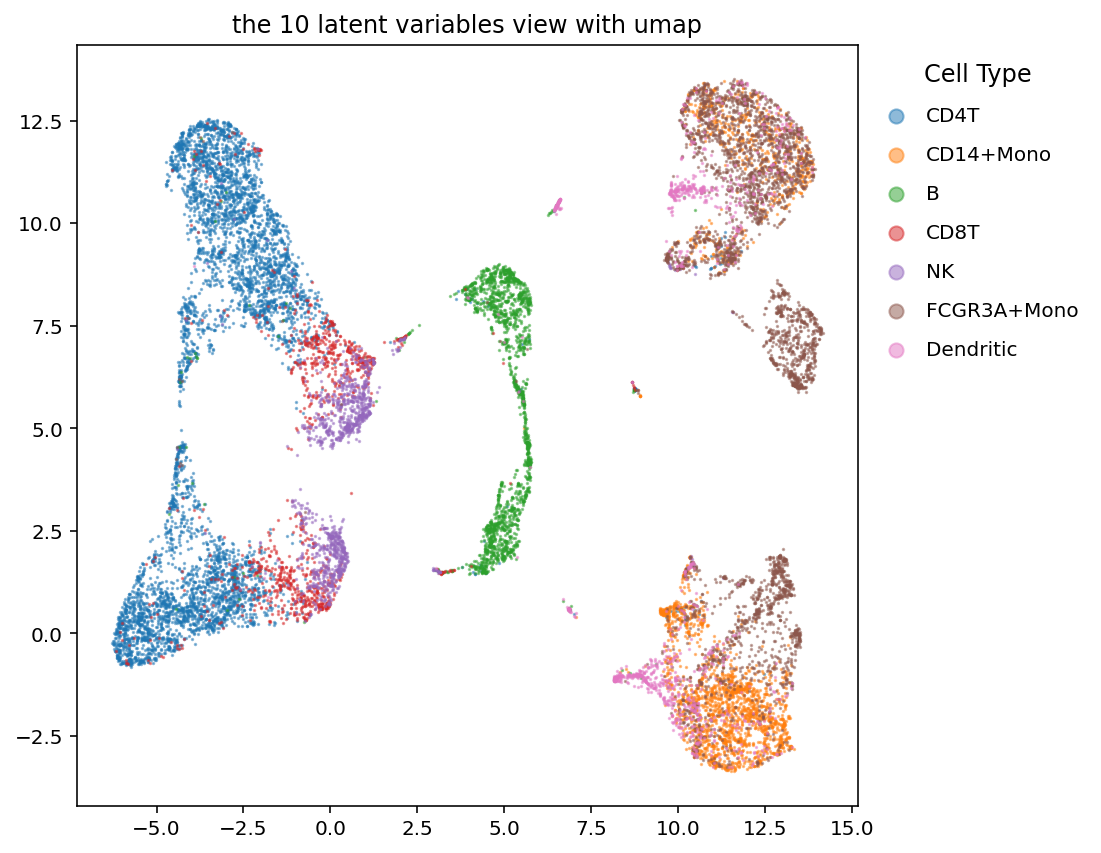

In [78]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
ax.set_title('the 10 latent variables view with umap')
for cell_type,cell_type_color in zip(adata.obs.cell_type.values.categories,adata.uns['cell_type_colors']):
    x = X_reduced[(adata.obs.cell_type==cell_type).values,0]
    y = X_reduced[(adata.obs.cell_type==cell_type).values,1]
    ax.scatter(x, y, c=cell_type_color,s=0.5,label=cell_type,alpha=0.5)

#ax.legend()
ax.legend(title = "Cell Type", 
          title_fontsize = "large",
          labelspacing = 1,
          handletextpad= 0.5,
          frameon=False, # 枠を消す
          markerscale = 10, # マーカーの大きさ
          loc='upper left', # 位置の設定
          bbox_to_anchor=(1, 1) # 位置の設定
          )
plt.savefig(f'figures/result_1.pdf', bbox_inches='tight', dpi=800)


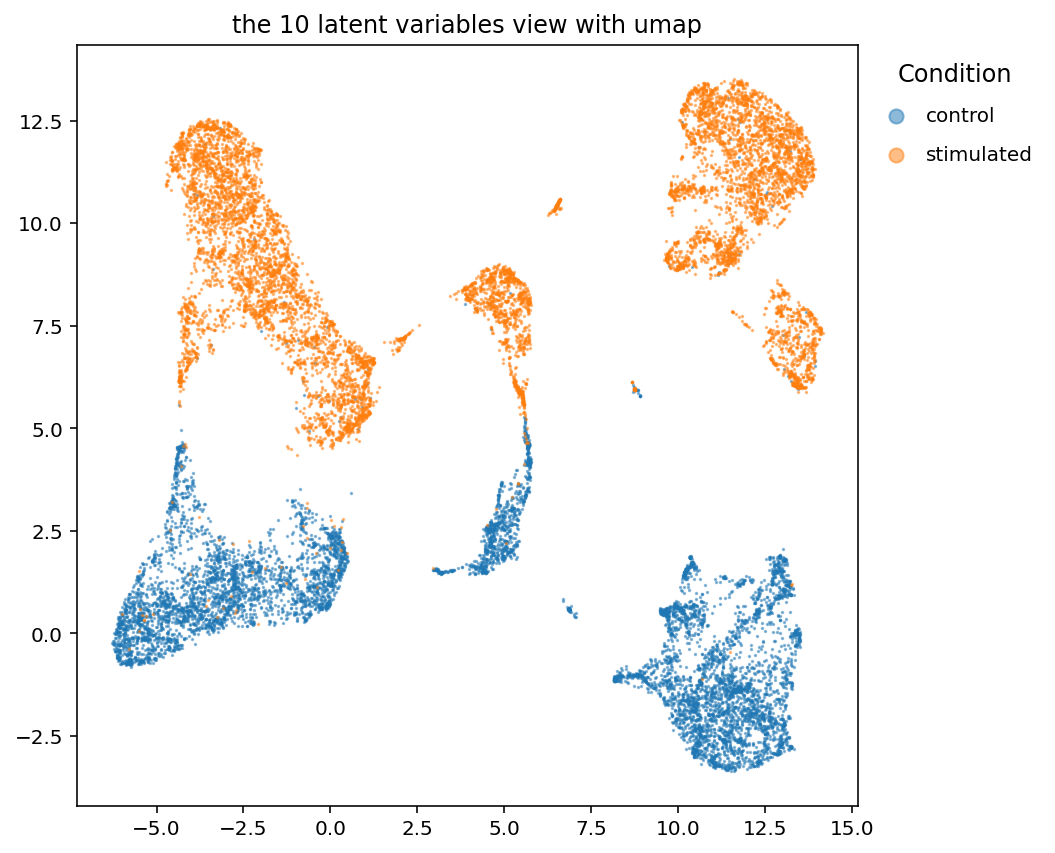

In [79]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
ax.set_title('the 10 latent variables view with umap')
for condition_type,condition_color in zip(adata.obs.condition.values.categories,adata.uns['condition_colors']):
    x = X_reduced[(adata.obs.condition==condition_type).values,0]
    y = X_reduced[(adata.obs.condition==condition_type).values,1]
    ax.scatter(x, y, c=condition_color,s=0.5,label=condition_type,alpha=0.5)

#ax.legend()
ax.legend(title = "Condition", 
          title_fontsize = "large",
          labelspacing = 1,
          handletextpad= 0.5,
          frameon=False, # 枠を消す
          markerscale = 10, # マーカーの大きさ
          loc='upper left', # 位置の設定
          bbox_to_anchor=(1, 1) # 位置の設定
          )
plt.savefig(f'figures/result_1.pdf', bbox_inches='tight', dpi=800)

In [ ]:
adata.uns['cell_type_colors']

array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
       '#e377c2'], dtype='<U7')

In [ ]:
def create_fig_0(num):
    plt.figure()
    figsize(7, 12 / 5)

    plt.subplot(1, 1, 1)

    plt.hist2d(
        Z_df_ordered[f'z'+str(num[0])], Z_df_ordered[f'z'+str(num[1])],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )

    plt.axis('equal')
    plt.xlabel('$Z_{}$ '.format(num[0]) + f'({variance_explained[idx][num[0]]:.1%} variance)')
    plt.ylabel('$Z_{}$ '.format(num[1]) + f'({variance_explained[idx][num[1]]:.1%} variance)')

    ax = plt.gca()

    color_maps = [cm.Reds_r, cm.Blues_r, cm.Greens_r]
    cell_types = ['CD4T', 'FCGR3A+Mono', 'CD14+Mono']
    for color, ctype in zip(color_maps, cell_types):
        X = metadata[metadata['cell_type']==ctype][['z'+str(num[0]), 'z'+str(num[1])]]
        xx1, xx2, f = make_kde(X['z'+str(num[0])], X['z'+str(num[1])])
        cset = ax.contour(
            xx1,
            xx2,
            f,
            levels=6,
            cmap=color,
            linewidths=1.
        )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig('figures/linear_pij_results_celltypes_{}_{}.pdf'.format(*num), bbox_inches='tight', dpi=400)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

KeyboardInterrupt: ignored

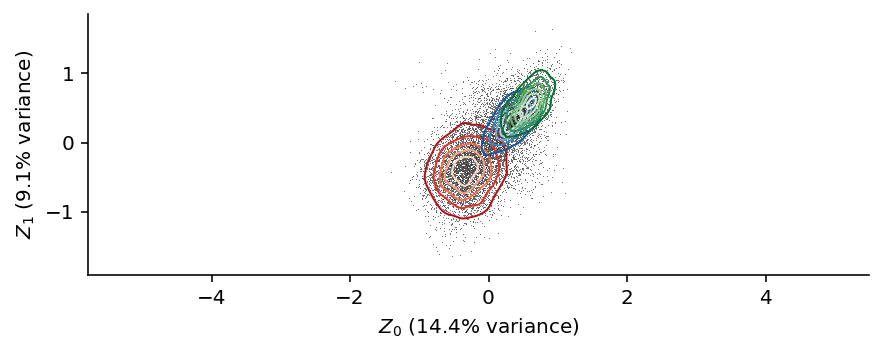

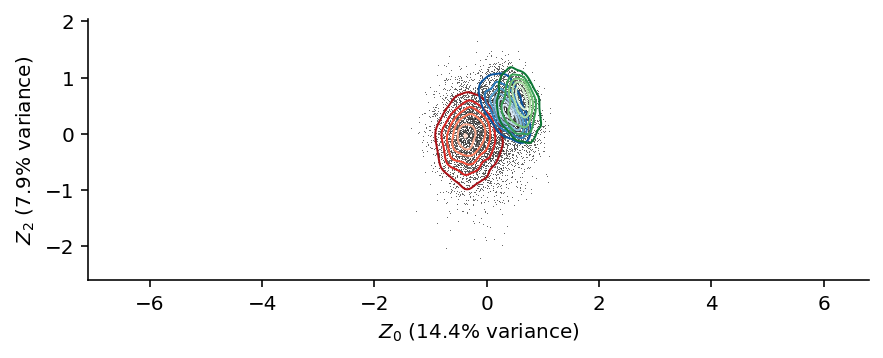

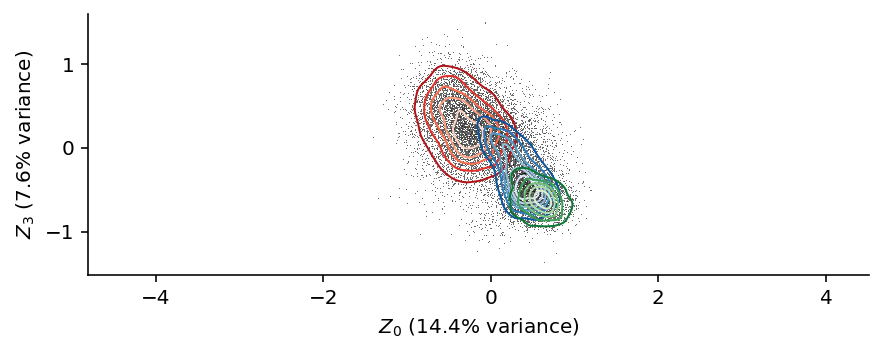

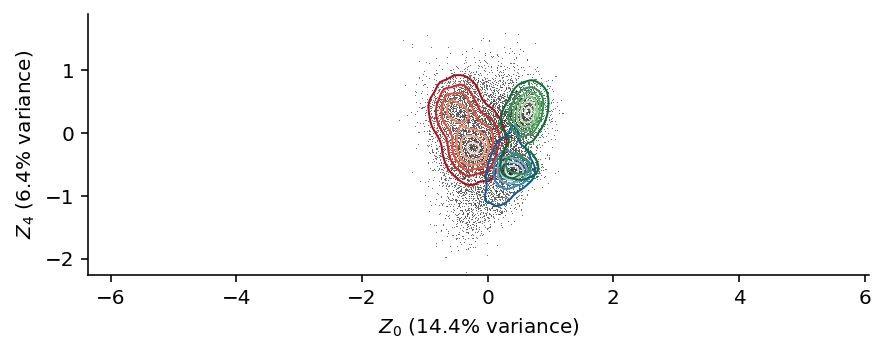

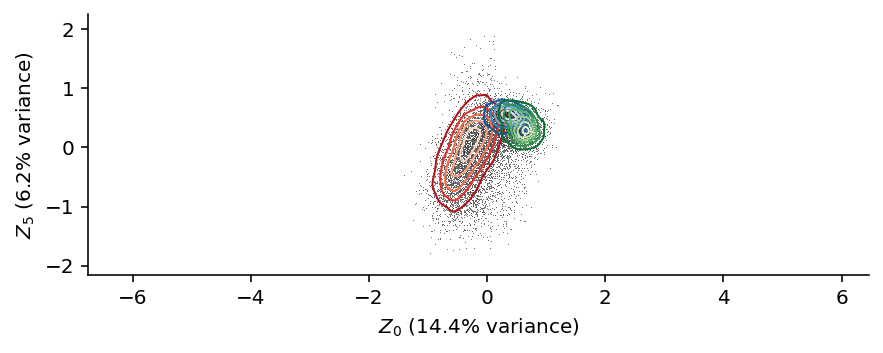

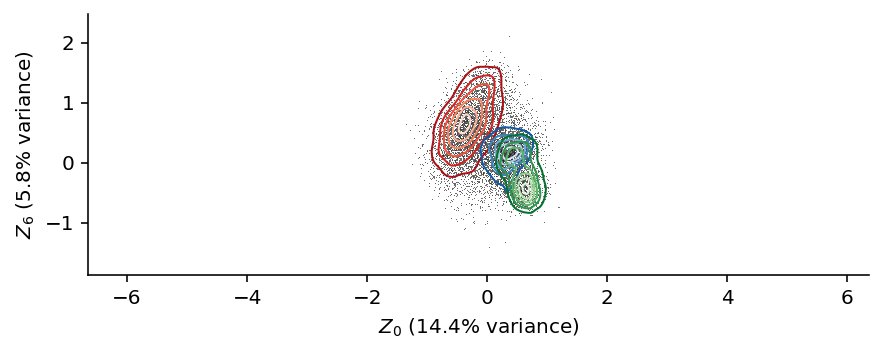

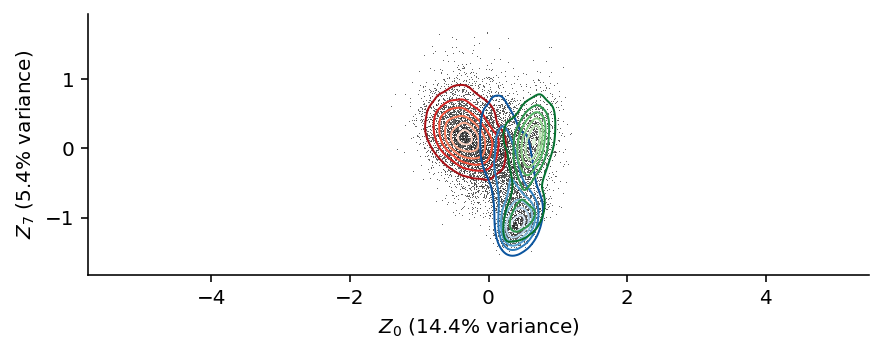

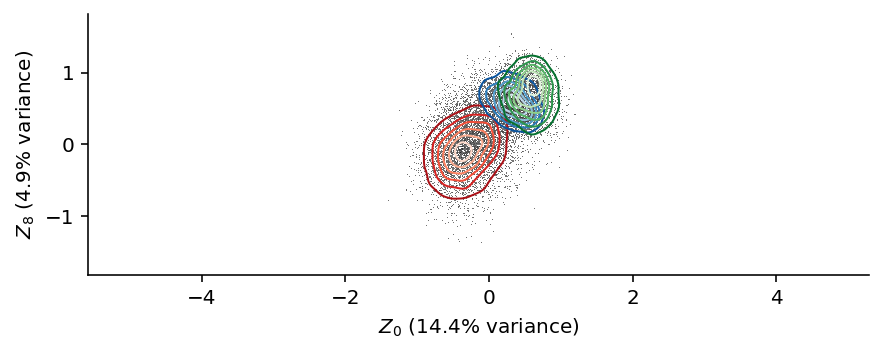

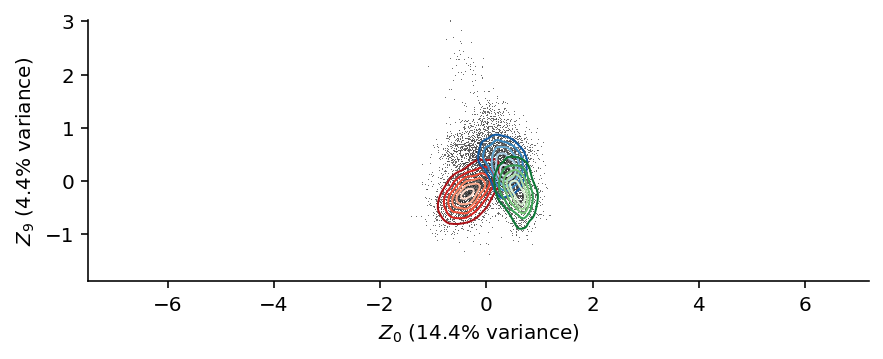

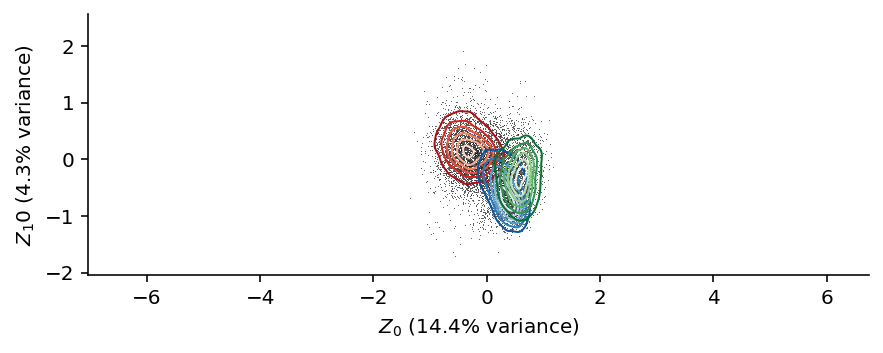

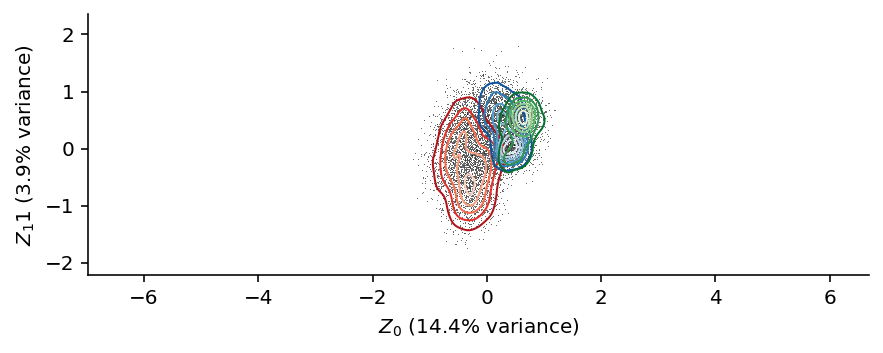

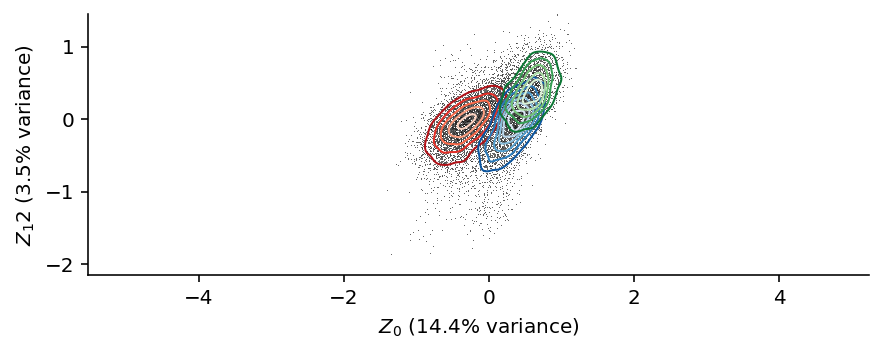

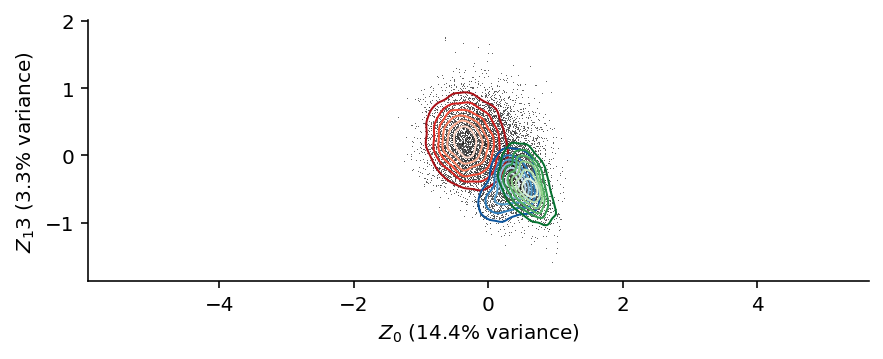

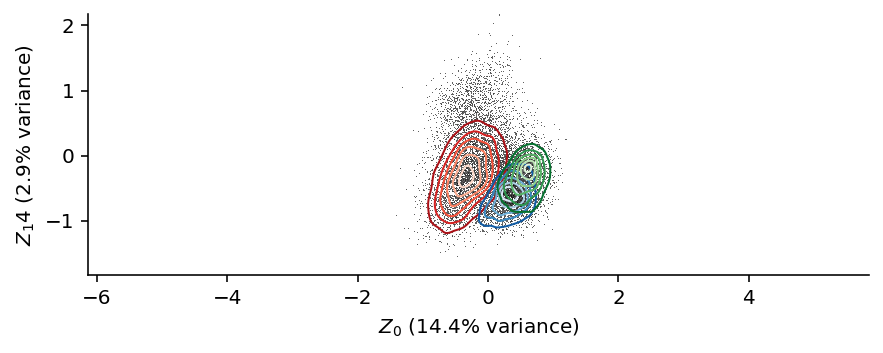

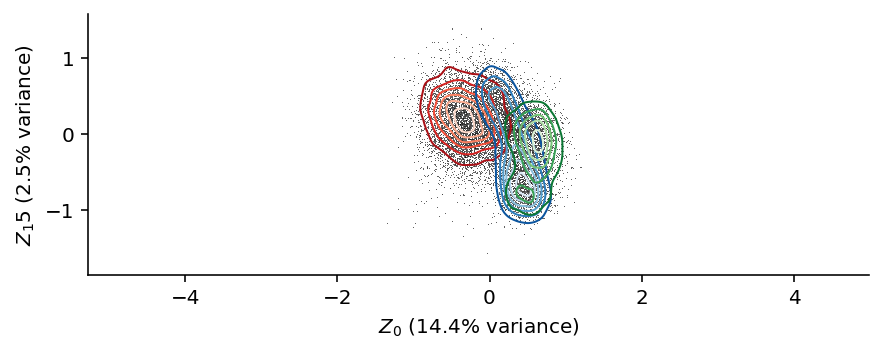

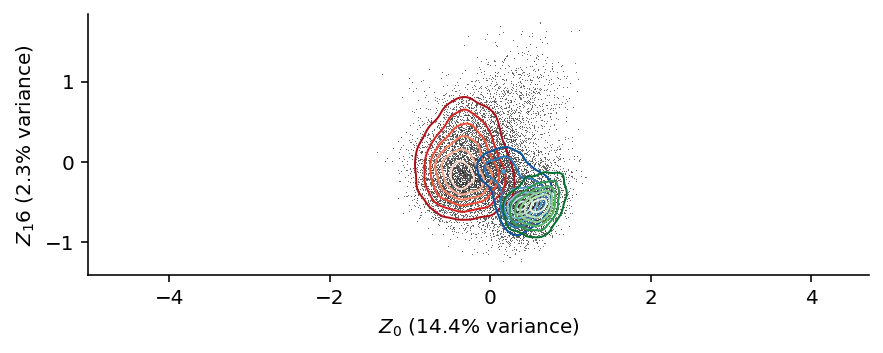

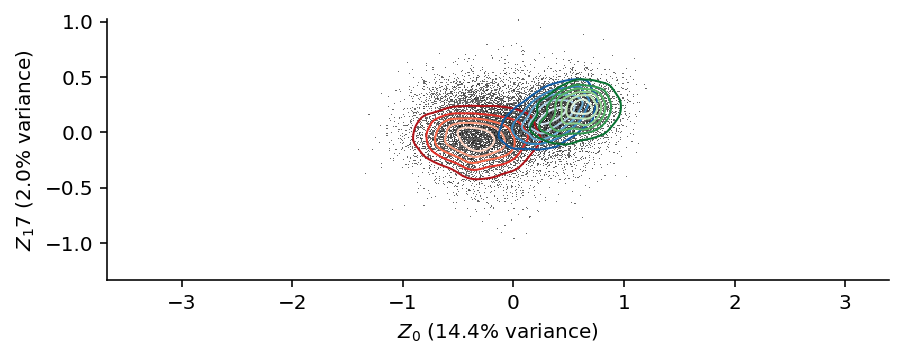

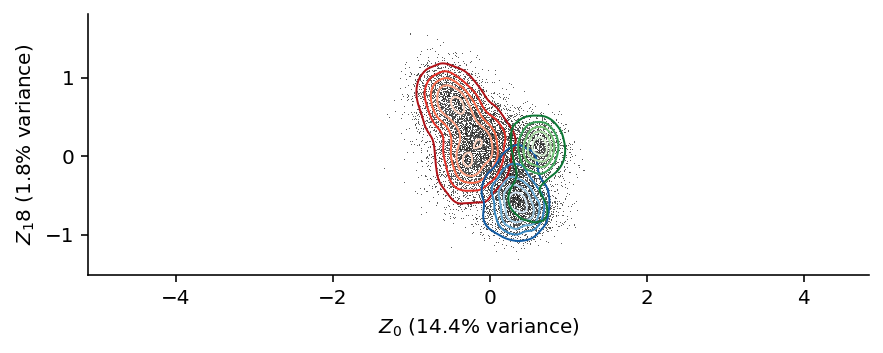

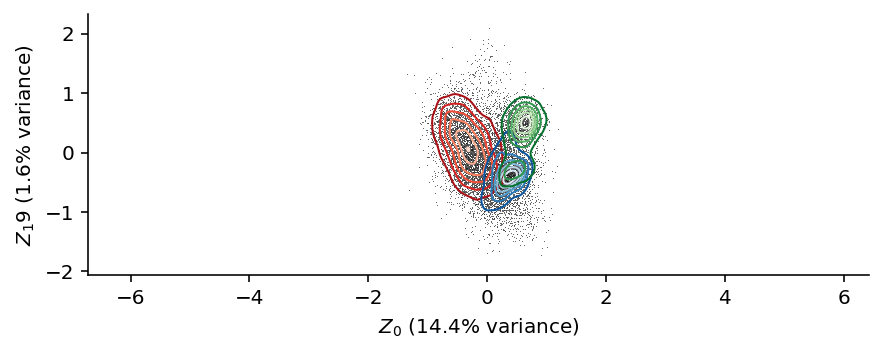

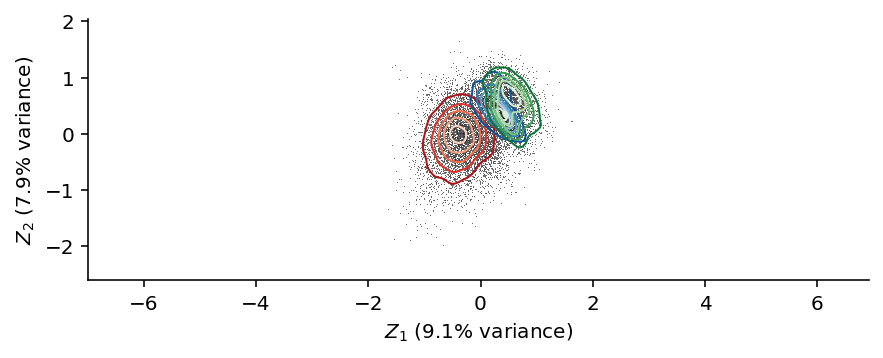

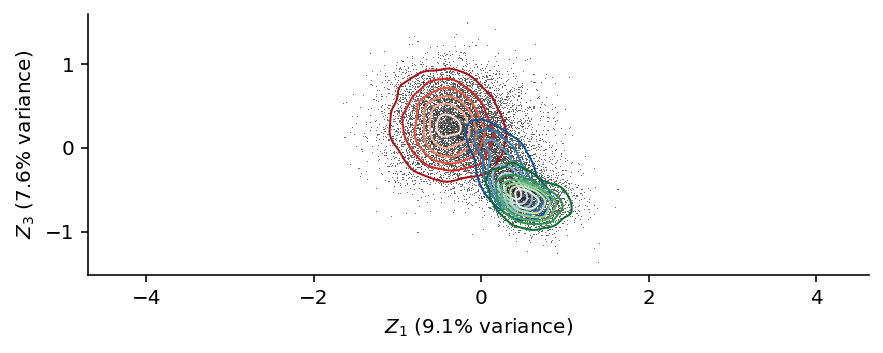

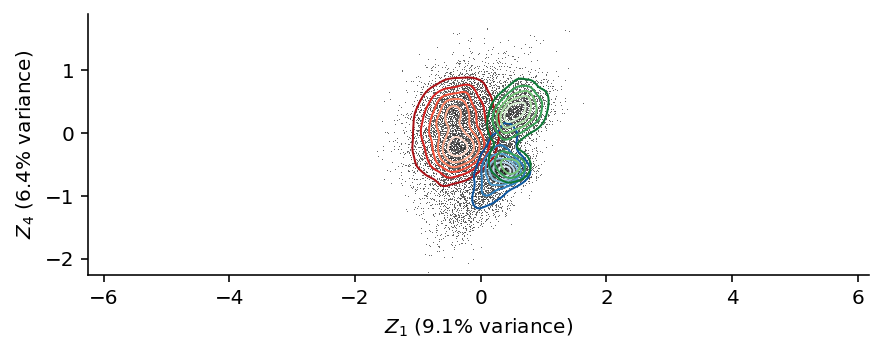

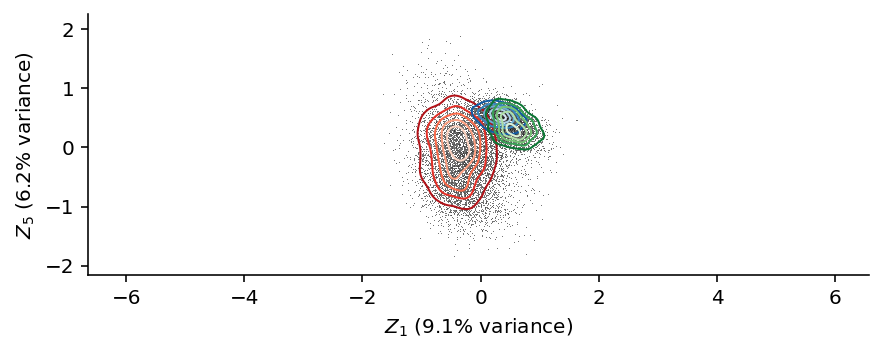

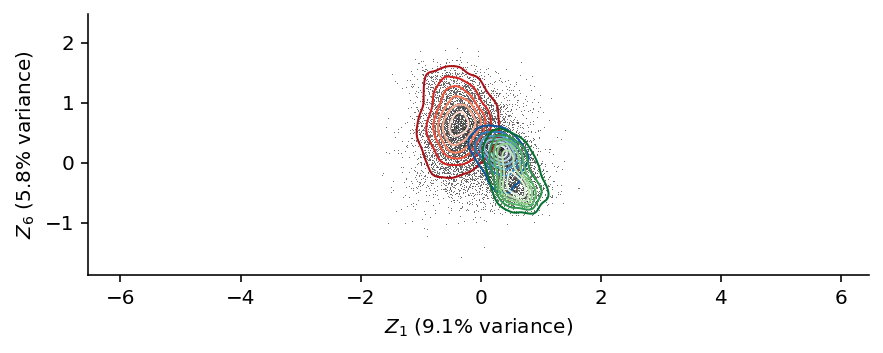

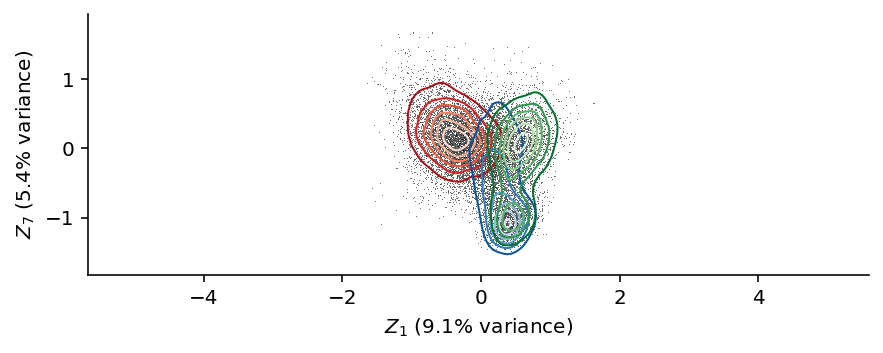

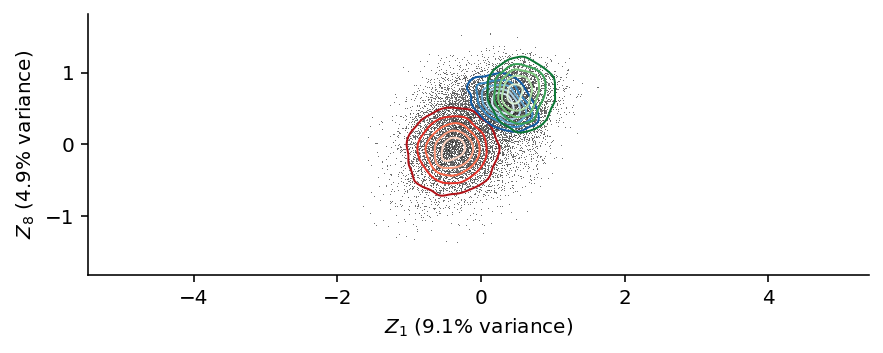

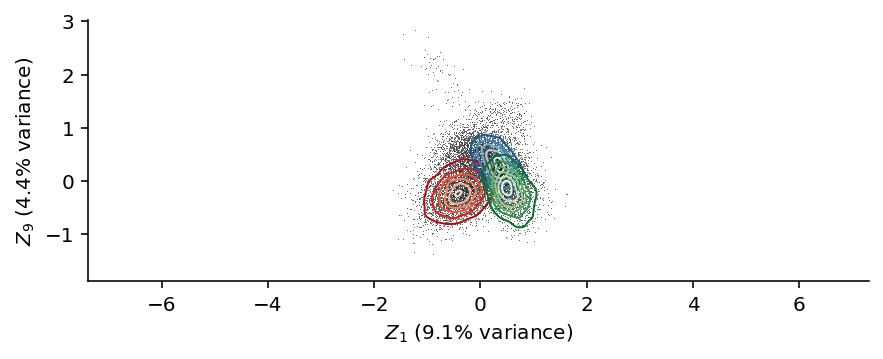

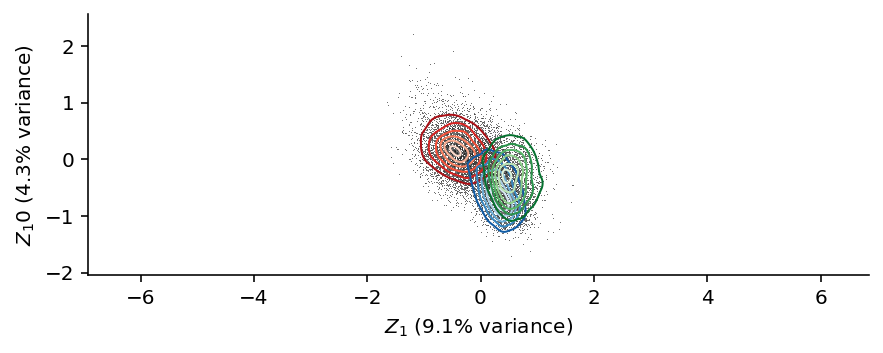

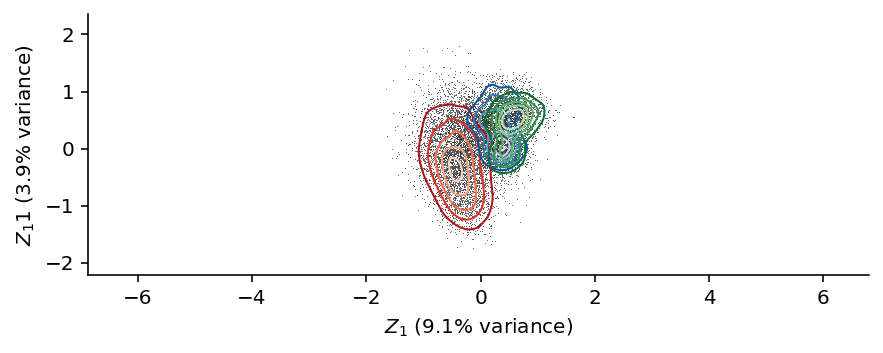

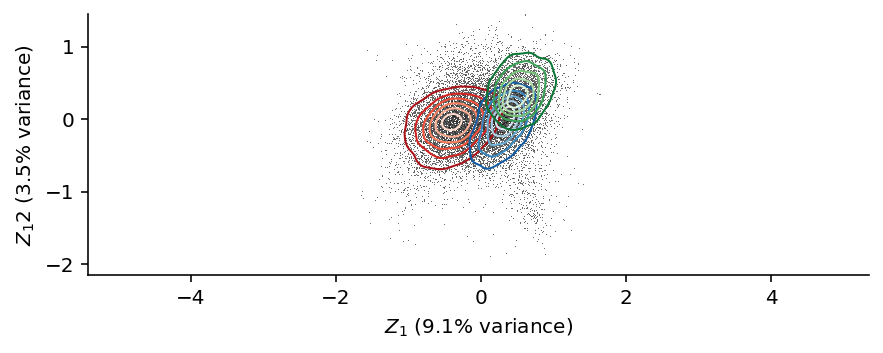

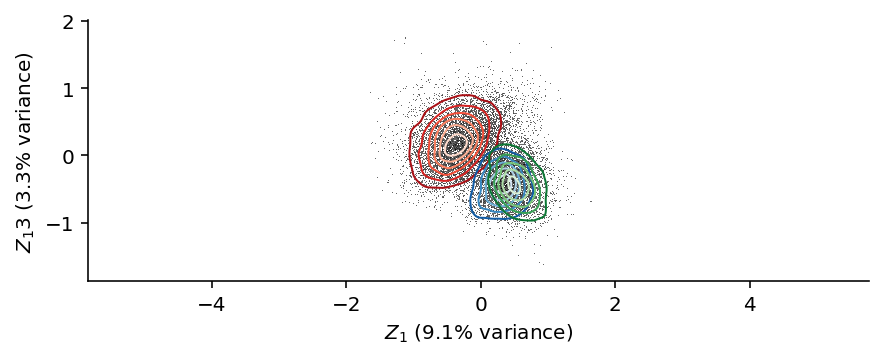

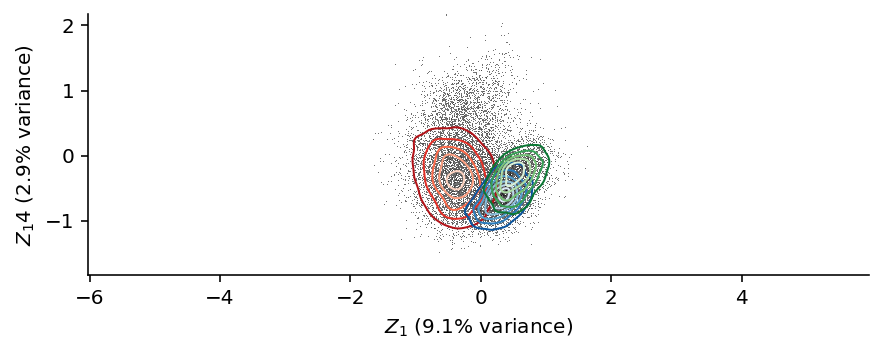

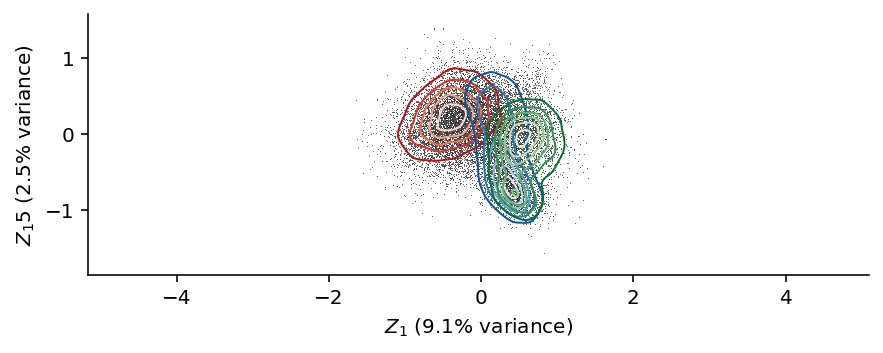

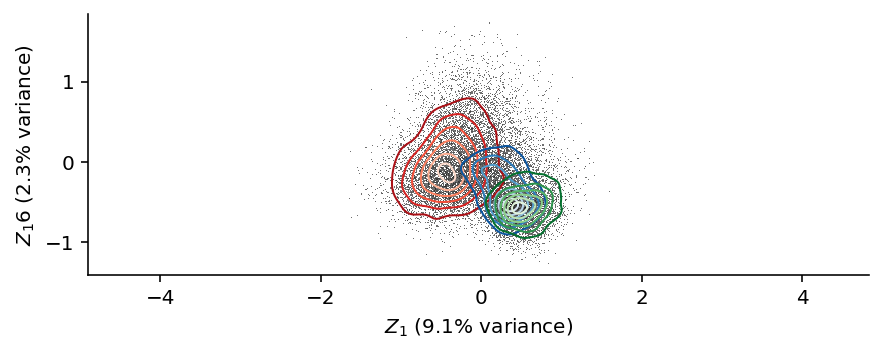

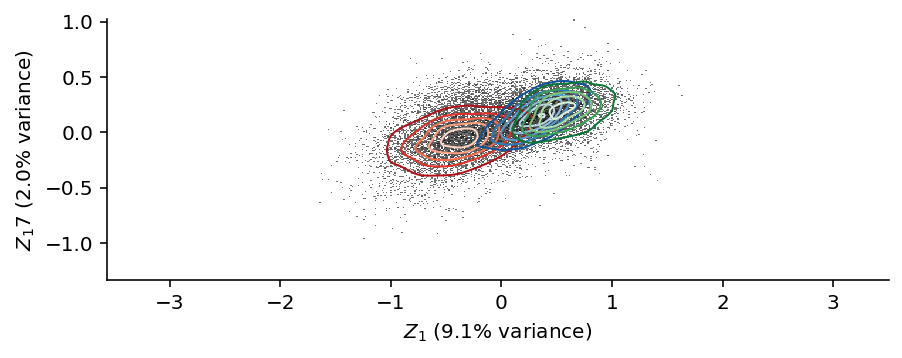

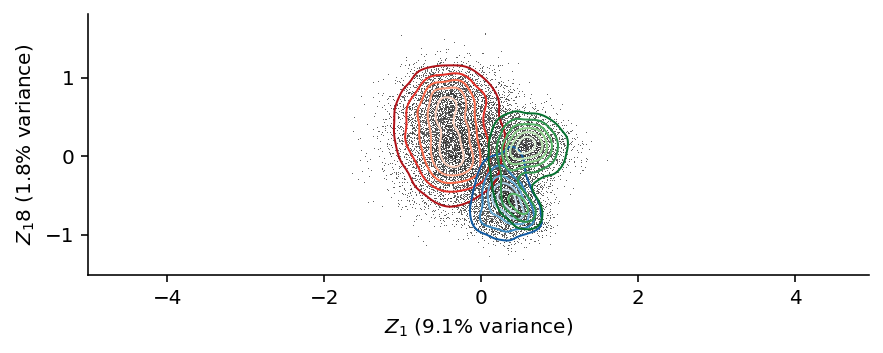

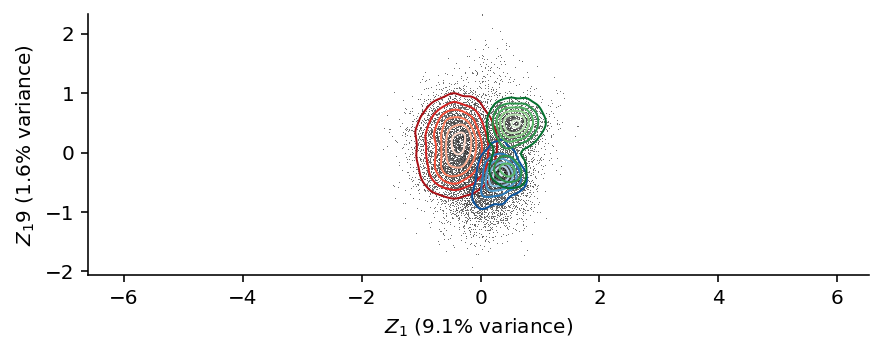

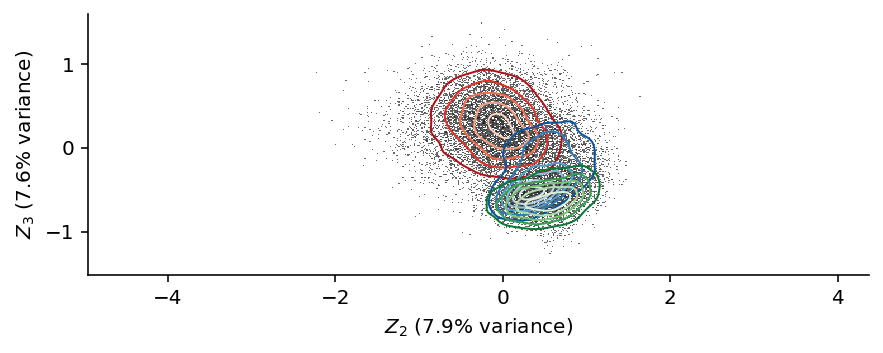

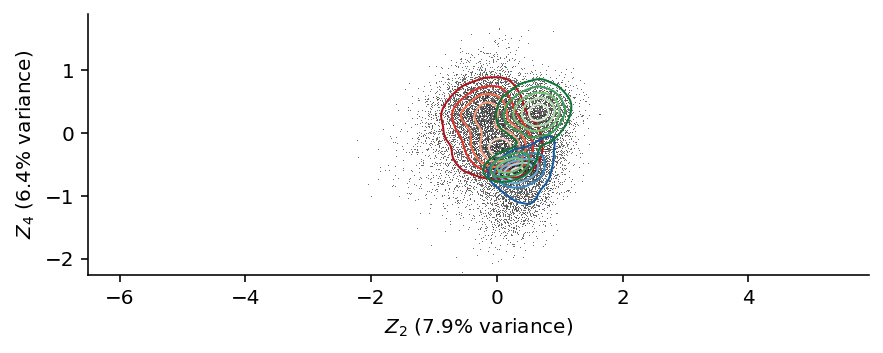

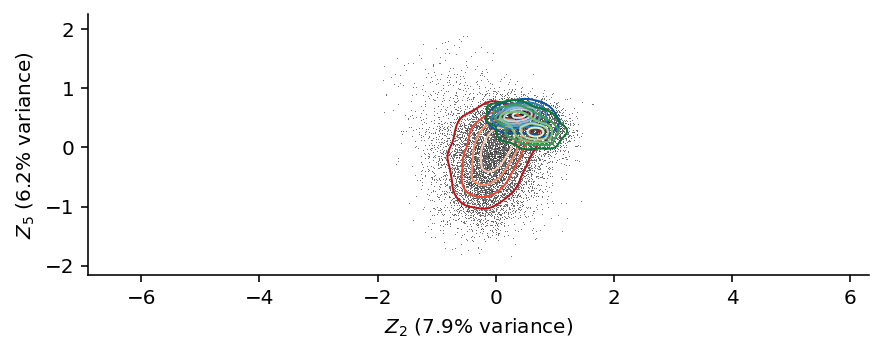

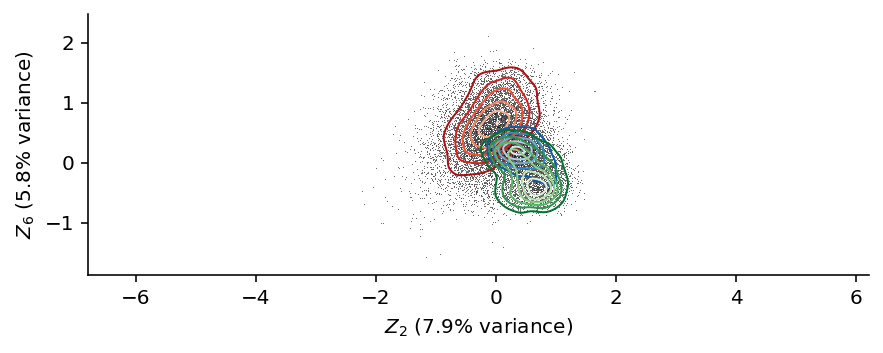

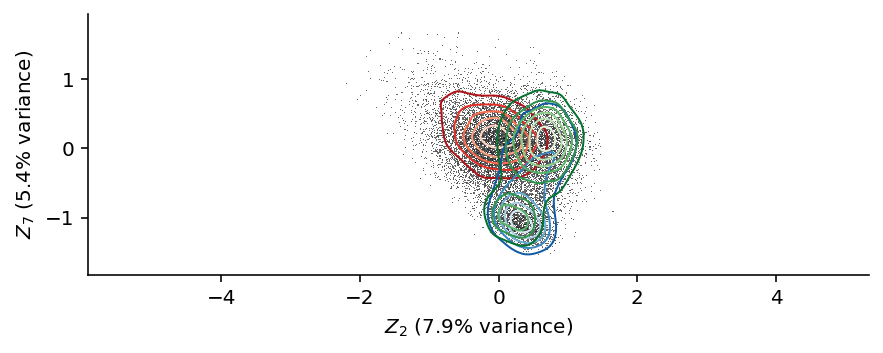

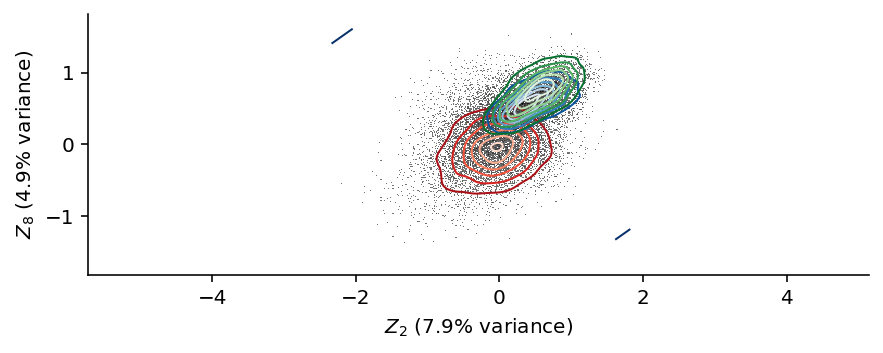

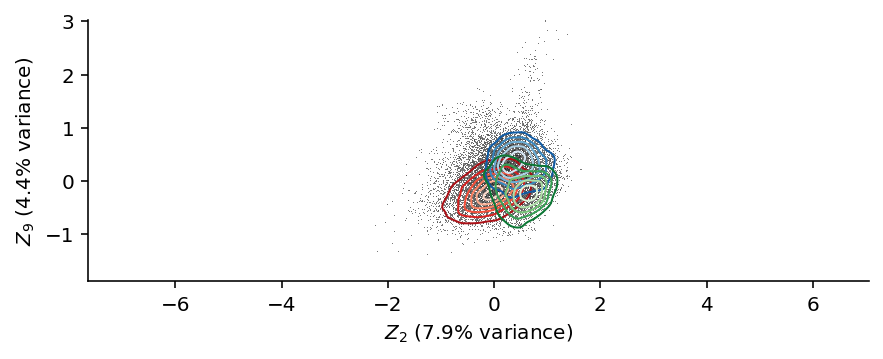

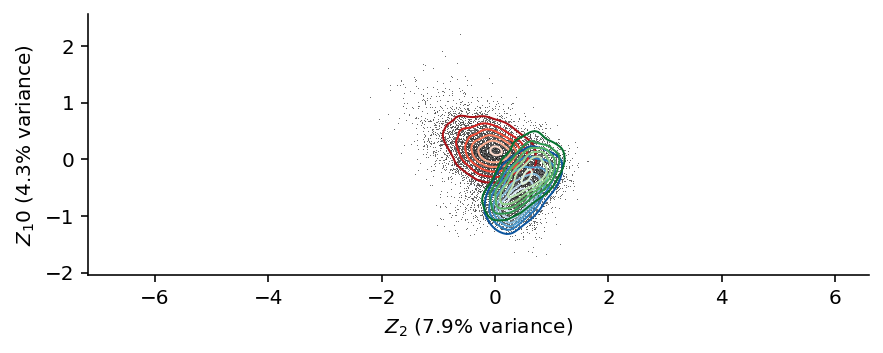

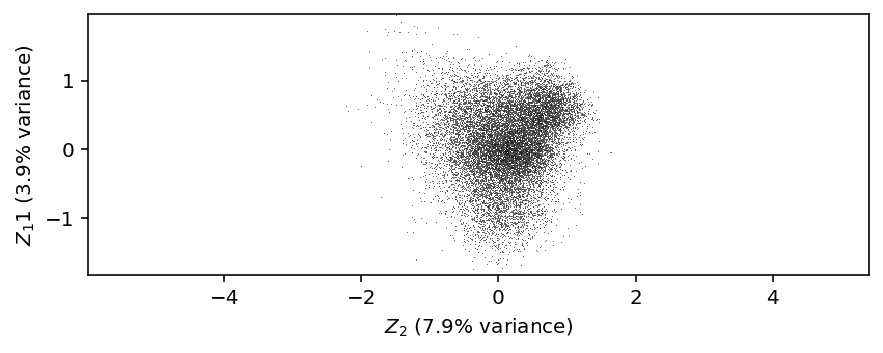

In [ ]:
for i in range(20):
    for j in range(i+1,20):
        create_fig_0((i,j))

In [ ]:
# ダウンロードしたいフォルダを zip 圧縮する
!zip -r /content/download.zip /content/figures

# 圧縮した zip ファイルをダウンロードする
from google.colab import files
files.download("/content/download.zip")

UndefinedVariableError: ignored

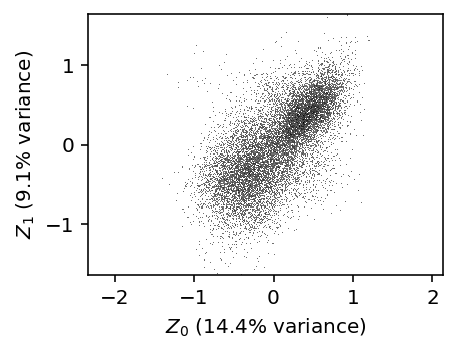

In [ ]:
num = (0,1)

figsize(7, 12 / 5)

plt.subplot(1, 2, 1)

plt.hist2d(
    Z_df_ordered[f'z'+str(num[0])], Z_df_ordered[f'z'+str(num[1])],
    bins=256,
    norm=mcolors.PowerNorm(0.25),
    cmap=cm.gray_r,
    rasterized=True
)

plt.axis('equal')
plt.xlabel('$Z_{}$ '.format(num[0]) + f'({variance_explained[idx][num[0]]:.1%} variance)')
plt.ylabel('$Z_{}$ '.format(num[1]) + f'({variance_explained[idx][num[1]]:.1%} variance)')

ax = plt.gca()

color_maps = [cm.Reds_r, cm.Blues_r, cm.Greens_r]
cell_types = ['Erythroid3', 'ExE endoderm', 'Epiblast']
for color, ctype in zip(color_maps, cell_types):
    X = metadata.query('celltype == @ctype')[['z'+str(num[0]), 'z'+str(num[1])]]
    xx1, xx2, f = make_kde(X['z'+str(num[0])], X['z'+str(num[1])])
    cset = ax.contour(
        xx1,
        xx2,
        f,
        levels=6,
        cmap=color,
        linewidths=1.
    )

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplot(1, 2, 2)

plt.scatter(
    W_df_ordered['w'+str(num[0])], W_df_ordered['w'+str(num[1])],
    c='lightgrey',
    rasterized=True
)


arrows = []
genes = ['Hbb-bs', 'Hbb-bt', 'Hba-a2']
for g in genes:
    x_, y_ = vardata.query('gene_name == @g')[['w'+str(num[0]), 'w'+str(num[1])]].values[0]

    arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='r'))
    
plt.text(0, 2, '\n'.join(genes), color='r')

arrows = []
genes = ['Pou5f1', 'Tdgf1', 'Snrpn']
for g in genes:
    x_, y_ = vardata.query('gene_name == @g')[['w'+str(num[0]), 'w'+str(num[1])]].values[0]

    arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='g'))

plt.text(1, -1.5, '\n'.join(genes), color='g')

arrows = []
genes = ['Ctsh', 'Amn', 'Apoa4']
for g in genes:
    x_, y_ = vardata.query('gene_name == @g')[['w'+str(num[0]), 'w'+str(num[1])]].values[0]

    arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='b'))

plt.text(-2.6, -0.5, '\n'.join(genes), color='b')


plt.xlim(left=-3, right=3)
plt.ylim(bottom=-3, top=3)

plt.xlabel('$W_{}$'.format(num[0]))
plt.ylabel('$W_{}$'.format(num[1]))

ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('figures/linear_pij_results_celltypes.pdf', bbox_inches='tight', dpi=400)



In [ ]:
figsize(80, 80)
z_length = 20
for i in range(z_length):
    for j in range(z_length):
        # -- Z plot --
    
        plt.subplot(z_length, z_length, z_length*i +j + 1)
        
        plt.hist2d(
            Z_df_ordered[f'z{i}'], Z_df_ordered[f'z{ j }'],
            bins=256,
            norm=mcolors.PowerNorm(0.25),
            cmap=cm.gray_r,
            rasterized=True
        )
        plt.axis('equal');
        plt.xlabel(f'$Z_{i}$ ({variance_explained[idx][i]:.1%} variance)')
        plt.ylabel(f'$Z_{j}$ ({variance_explained[idx][ j]:.1%} variance)')
        
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.savefig('figures/linear_pij_results.pdf', bbox_inches='tight', dpi=20)

In [ ]:


text_shift = {
    (0, 'Fst'): (0.2, -0.2),
    (0, 'Pmp22'): (-0.1, -0.3),
    (0, 'Hoxaas3'): (0.0, 0.3),
    (0, 'Acta2'): (0.0, 0.2),
    (0, 'Nnat'): (0.0, 0.5),
    (0, 'Ifitm1'): (0.0, 0.2),
    
    (1, 'Srgn'): (0., -0.2),
    (1, 'Amn'): (-0.7, 0.),
    
    (2, 'Crabp2'): (0.0, 0.4),
    (2, 'Tdgf1'): (0.0, 0.4),
    (2, 'Cer1'): (-0.6, 0.0),
    (2, 'T'): (-1.3, 0.0),
    
    (3, 'Cdx1'): (0.0, 0.4),
    (3, 'Cdx2'): (-1.0, 0.7),
    (3, 'Cited1'): (-1.6, -0.0),
    (3, 'Phlda2'): (-0.7, 0.0),
    (3, 'T'): (0.0, 0.2),
    (3, 'Ifitm1'): (-0.2, 0.0),
#     (3, 'Rspo2'): (-0.3, 0.0),
#     (3, 'Htr2c'): (0.6, 0.1),
#     (3, 'Col1a1'): (0.0, 0.2),
    
#     (4, 'Ttn'): (0.0, -0.4),
#     (4, 'Sntb1'): (0.0, -0.3),
#     (4, 'Colec12'): (-1.1, 0.1),
#     (4, 'Adam12'): (0.1, 0.4),
#     (4, 'Spon1'): (0.0, 0.2),
#     (4, 'Gm3764'): (-0.2, 0.3),
#     (4, 'C130071C03Rik'): (1.5, -0.35),
    
}



In [ ]:

figsize(7, 12)
for i in range(5):
    
    # -- Z plot --
    
    plt.subplot(5, 2, 2 * i + 1)
    
    plt.hist2d(
        Z_df_ordered[f'z{2 * i}'], Z_df_ordered[f'z{2 * i + 1}'],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )
    plt.axis('equal');
    plt.xlabel(f'$Z_{2 * i}$ ({variance_explained[idx][2 * i]:.1%} variance)')
    plt.ylabel(f'$Z_{2 * i + 1}$ ({variance_explained[idx][2 * i + 1]:.1%} variance)')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    

    #plt.xlim(left=-3, right=3)
    #plt.ylim(bottom=-3, top=3)
    
plt.tight_layout()
plt.savefig('figures/linear_pij_results.pdf', bbox_inches='tight', dpi=400)